In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/README.txt
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/1569_jpg.rf.dc675613d5fce07e505cba269b91fffb.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/1345_jpg.rf.54fa804d2c5aa5ee150120987469bc56.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2578_jpg.rf.d050cac989e96e1beb221b4b22b93e82.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/1097_jpg.rf.df6c35b4ed24ef8c28138939567ef7ab.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2145_jpg.rf.04fd7a826343eea802b676b730f12ae3.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2061_jpg.rf.d04d5d6171939764f6e239a960e95e02.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2776_jpg.rf.b87922fb0539b4565c732d8cc107507b.jpg
/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/2001_jpg.rf.1e0b2ddfc86e0023d5937a105ab2

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from pycocotools.coco import COCO


In [3]:
train_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train'
val_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid'
test_dir = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test'

train_annotation_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/_annotations.coco.json'
test_annotation_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/_annotations.coco.json'
val_annotation_file = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json'

In [4]:
train_coco = COCO(train_annotation_file)
val_coco = COCO(val_annotation_file)
test_coco = COCO(test_annotation_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
def load_image_and_mask(coco, image_dir, image_id):
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = Image.open(image_path)
    image = np.array(image)

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((image_info['height'], image_info['width']))
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return image, mask

In [6]:
def create_tf_dataset(coco, image_dir, image_ids):
    def generator():
        for image_id in image_ids:
            yield load_image_and_mask(coco, image_dir, image_id)

    return tf.data.Dataset.from_generator(generator,
                                          output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8), 
                                                            tf.TensorSpec(shape=(None, None), dtype=tf.uint8)))

train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())

In [7]:
def preprocess(image, mask):
    
    image = tf.image.resize(image, (256, 256))
    
    mask = tf.expand_dims(mask, axis=-1)  
    mask = tf.image.resize(mask, (256, 256))
 
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, mask

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

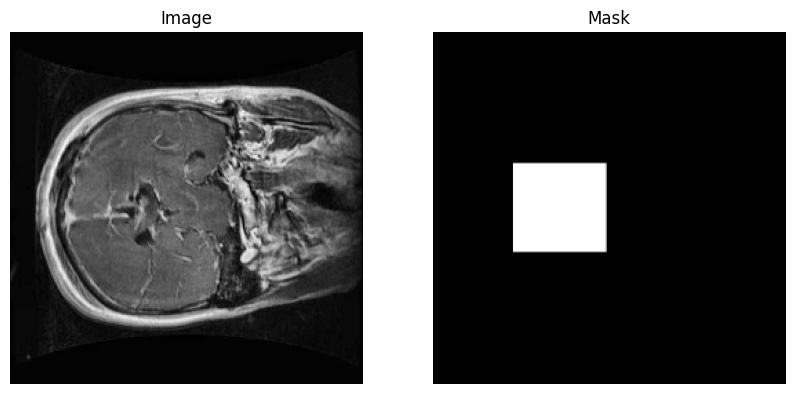

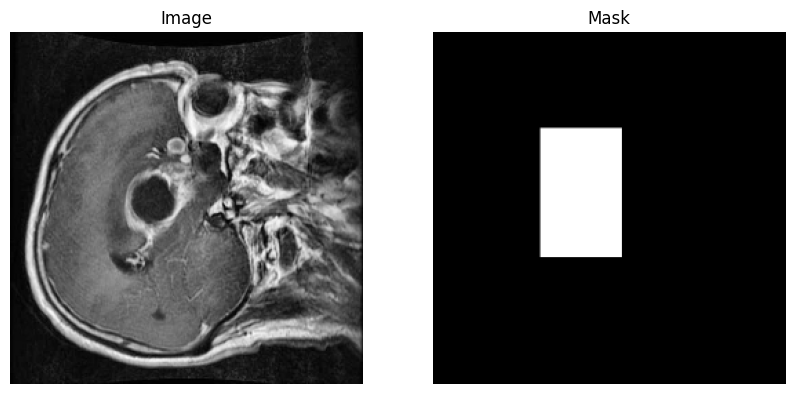

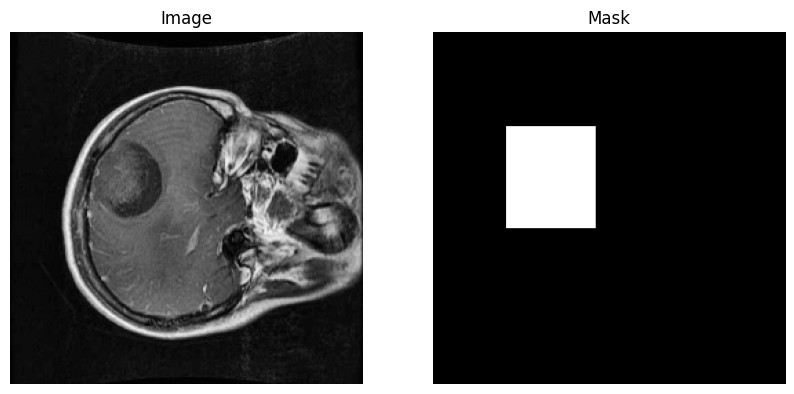

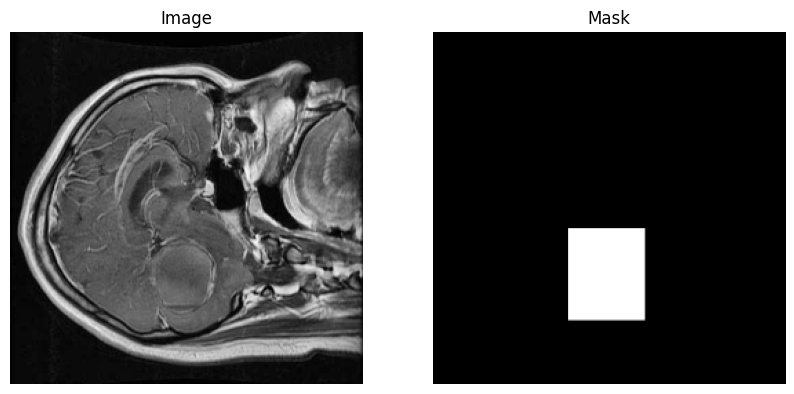

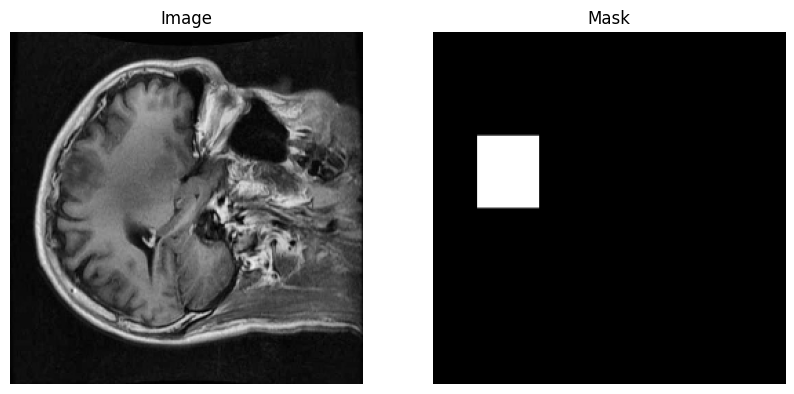

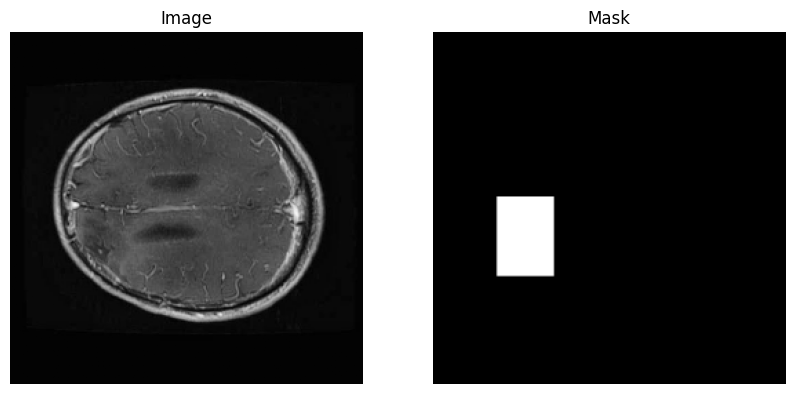

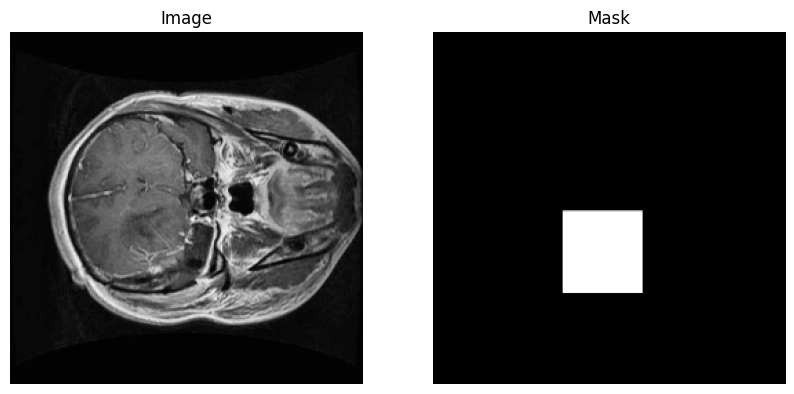

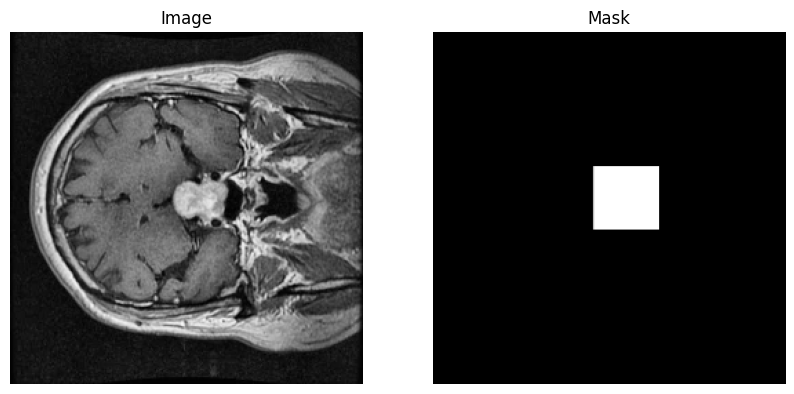

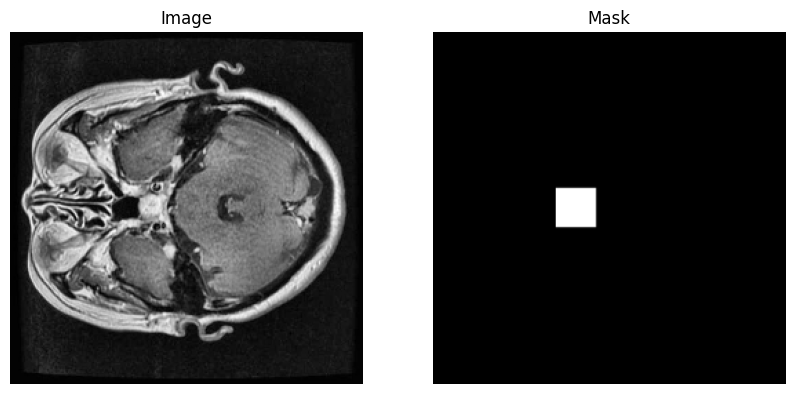

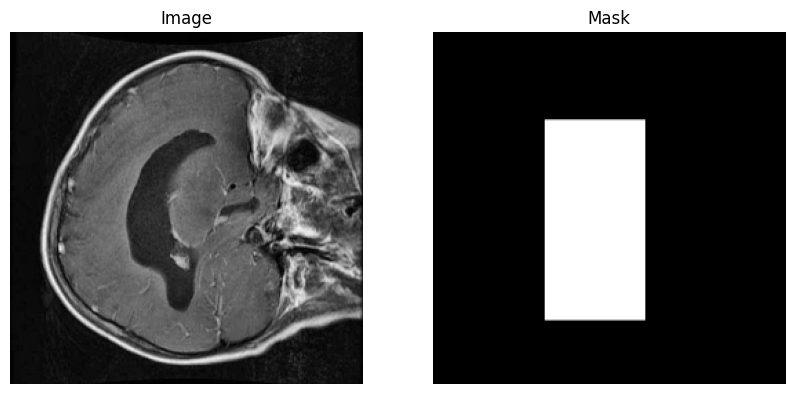

In [8]:
def visualize_dataset(dataset, num_samples=5):
    for i, (image, mask) in enumerate(dataset.take(num_samples)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy())
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy().squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.show()

visualize_dataset(train_dataset)
visualize_dataset(val_dataset)


In [9]:
def downsampling_block(x, n_filters):
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def upsampling_block(x, skip_connection, n_filters):
    u = layers.Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)
    u = layers.concatenate([u, skip_connection])
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(u)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    return c

def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1):
    inputs = layers.Input(input_size)
    dblock1, p1 = downsampling_block(inputs, n_filters)
    dblock2, p2 = downsampling_block(p1, n_filters * 2)
    dblock3, p3 = downsampling_block(p2, n_filters * 4)
    dblock4, p4 = downsampling_block(p3, n_filters * 8)

    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(p4)
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(bottleneck)

    u6 = upsampling_block(bottleneck, dblock4, n_filters * 8)
    u7 = upsampling_block(u6, dblock3, n_filters * 4)
    u8 = upsampling_block(u7, dblock2, n_filters * 2)
    u9 = upsampling_block(u8, dblock1, n_filters)

    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid' if n_classes == 1 else 'softmax')(u9)

    model = models.Model(inputs, outputs)

    return model

model = unet_model(input_size=(256, 256, 3), n_filters=32)

In [10]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce

metrics = ["accuracy", dice_coef]

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=combined_loss, metrics=metrics)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = len(train_coco.getImgIds()) // BATCH_SIZE
validation_steps = len(val_coco.getImgIds()) // BATCH_SIZE
test_steps = len(test_coco.getImgIds()) // BATCH_SIZE

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1645s 18s/step - accuracy: 0.9618 - dice_coef: 0.0538 - loss: 0.7716 - val_accuracy: 0.9627 - val_dice_coef: 0.1603 - val_loss: 0.5678 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1628s 18s/step - accuracy: 0.9615 - dice_coef: 0.1710 - loss: 0.5623 - val_accuracy: 0.9622 - val_dice_coef: 0.2057 - val_loss: 0.5445 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1609s 17s/step - accuracy: 0.9612 - dice_coef: 0.2133 - loss: 0.5335 - val_accuracy: 0.9627 - val_dice_coef: 0.2183 - val_loss: 0.5265 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1613s 17s/step - accuracy: 0.9614 - dice_coef: 0.2292 - loss: 0.5217 - val_accuracy: 0.9621 - val_dice_coef: 0.2219 - val_loss: 0.5226 - learning_rate: 1.0000e-04
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1618s 17s/step - accuracy: 0.9196 - dice_coef: 0.2361 - loss: 0.5179 - val_accuracy: 0.9449 - val_dice_coef: 0.2403 - val_loss: 0.5192 - learning_rate: 1.0000e-04


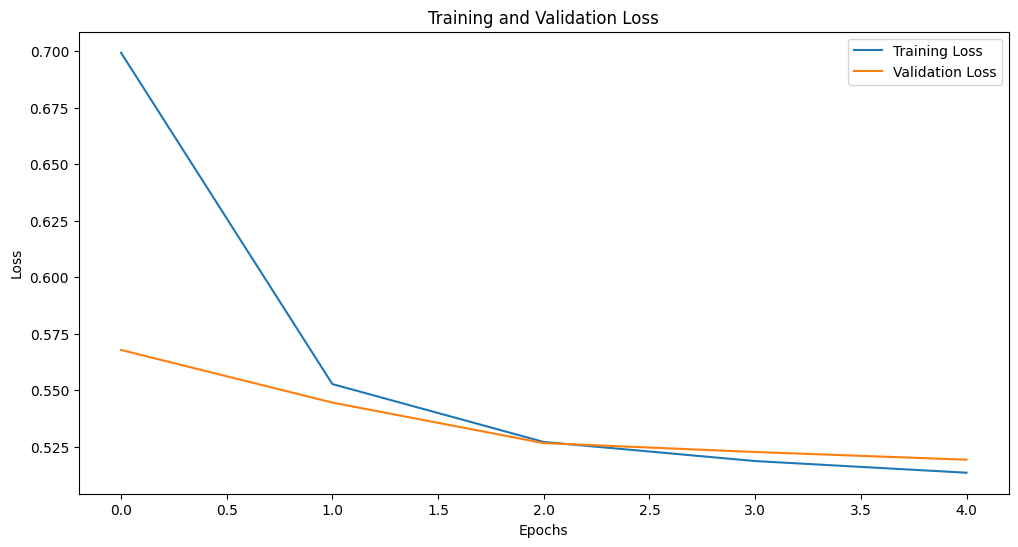

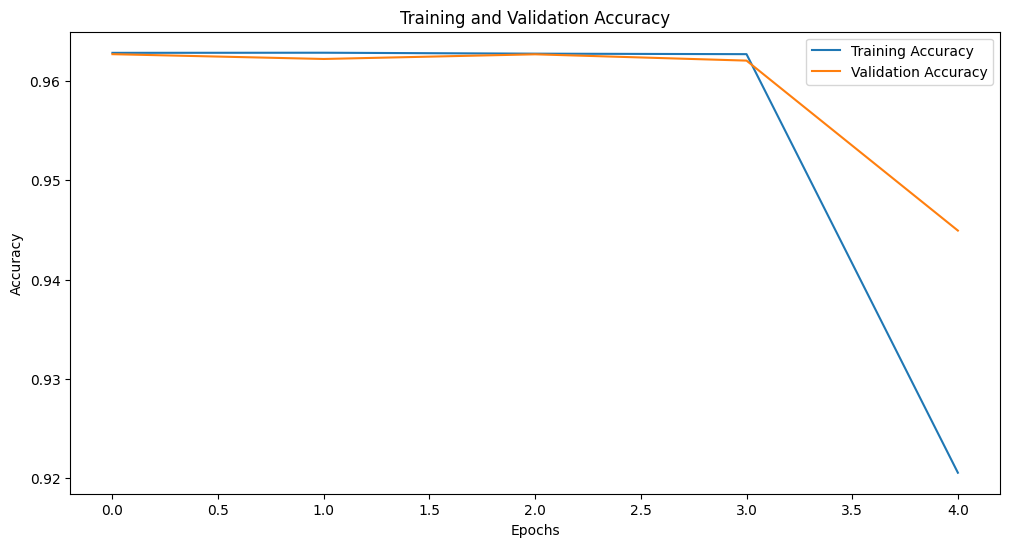

In [13]:
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_loss(history)
plot_accuracy(history)

In [24]:
test_loss, test_accuracy, test_coef = model.evaluate(test_dataset, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Dice Coefficient: {test_coef}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - accuracy: 0.9404 - dice_coef: 0.2421 - loss: 0.5184
Test Loss: 0.5183403491973877, Test Accuracy: 0.9422839879989624, Test Dice Coefficient: 0.23695015907287598


In [15]:
def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):

    random_batch = random.choice(list(dataset))
    images, masks = random_batch

    indices = random.sample(range(len(images)), min(num_samples, len(images)))

    predictions = model.predict(images)

    binary_predictions = (predictions > threshold).astype('uint8')

    for i in indices:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(binary_predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()


In [16]:
import random

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


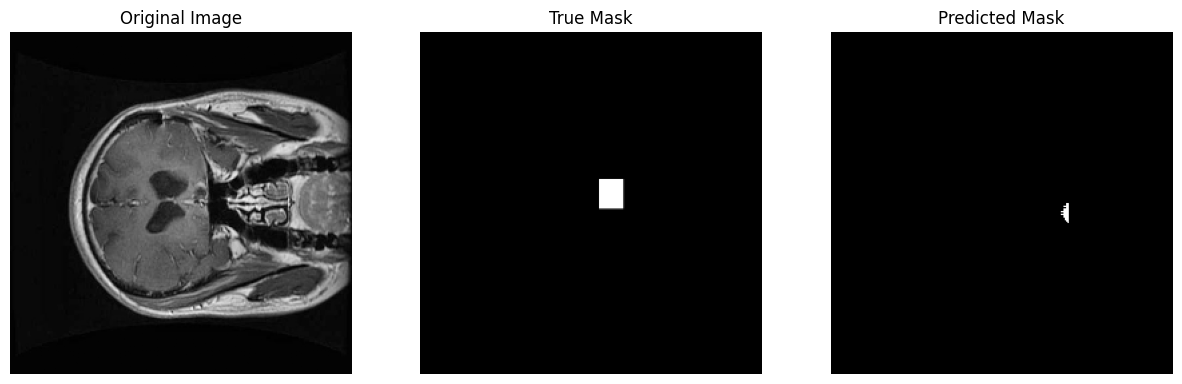

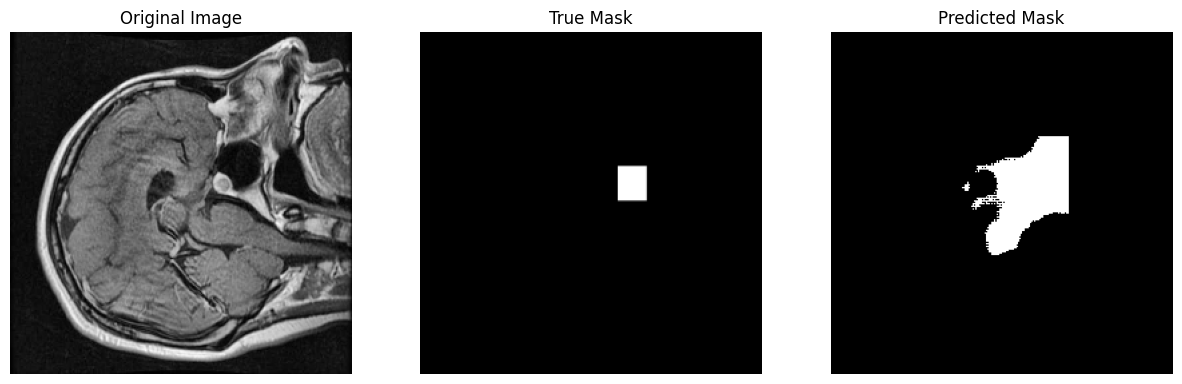

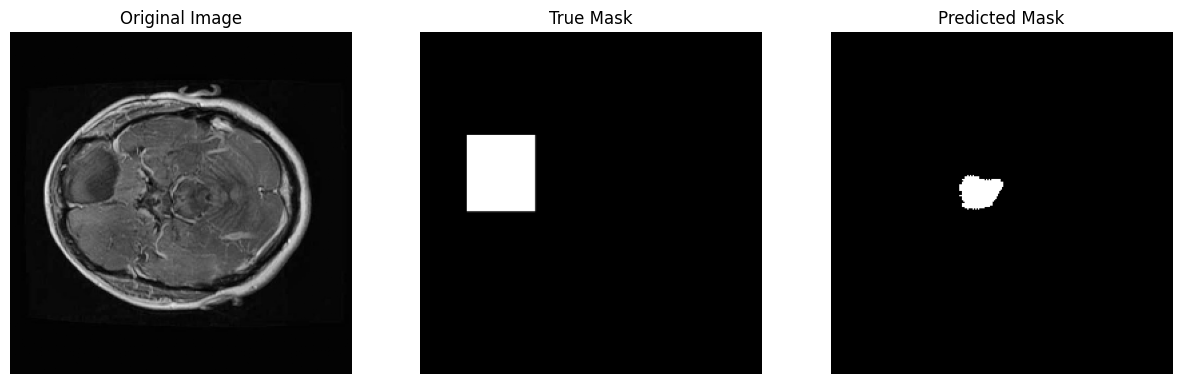

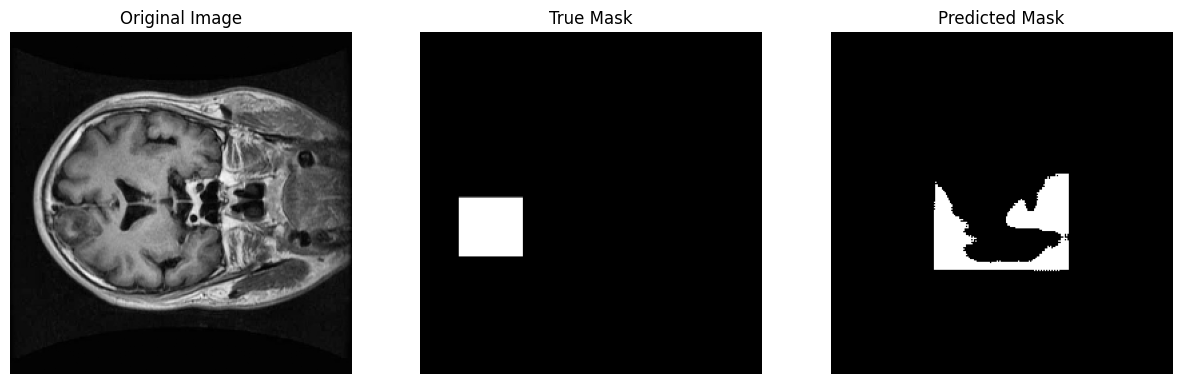

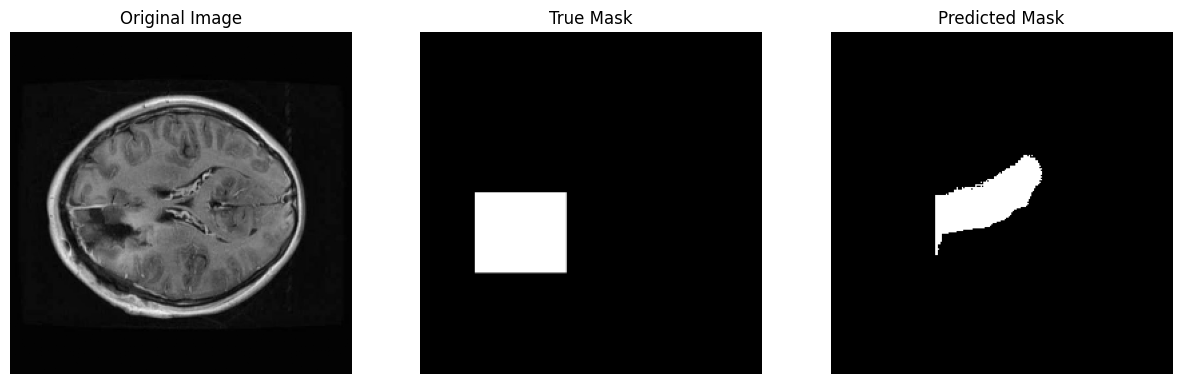

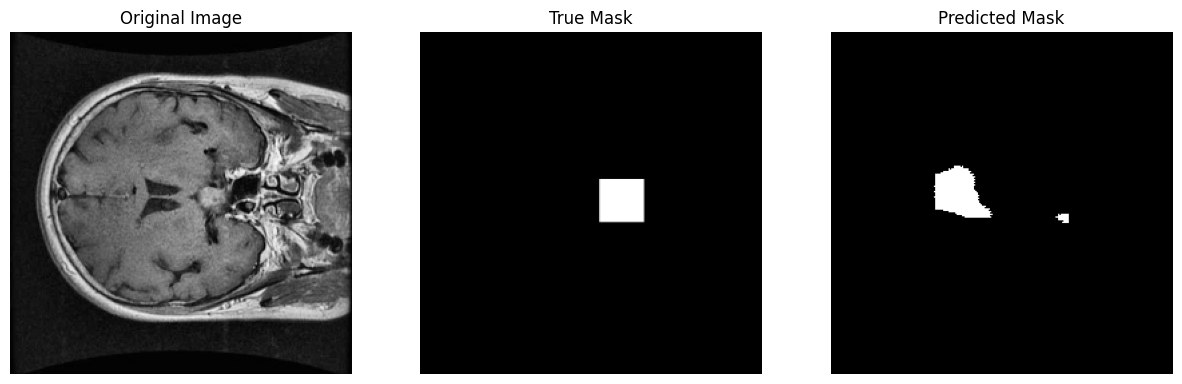

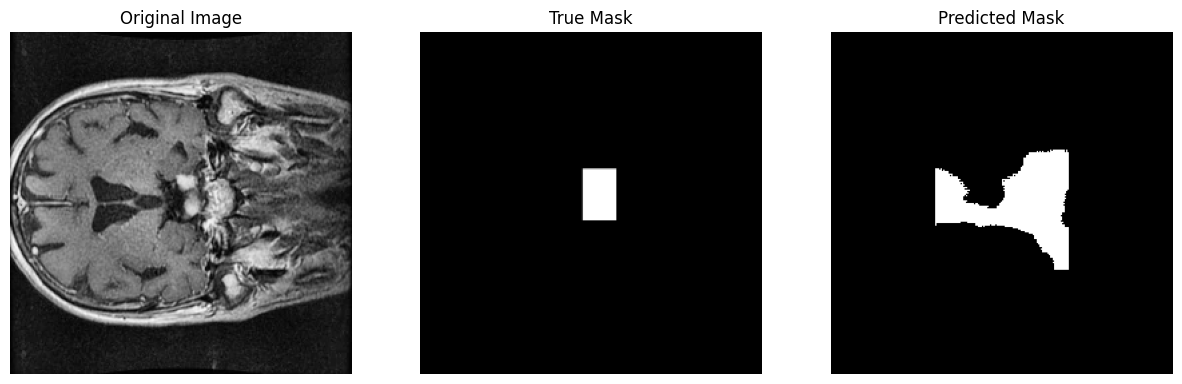

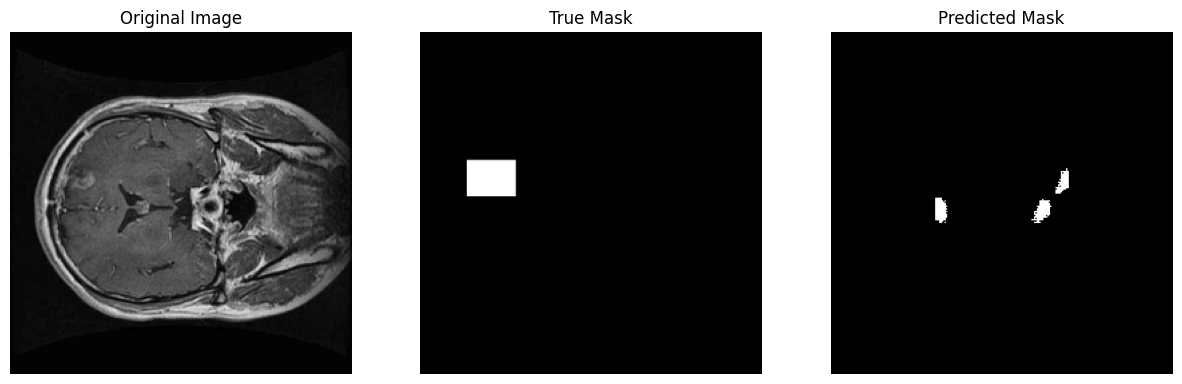

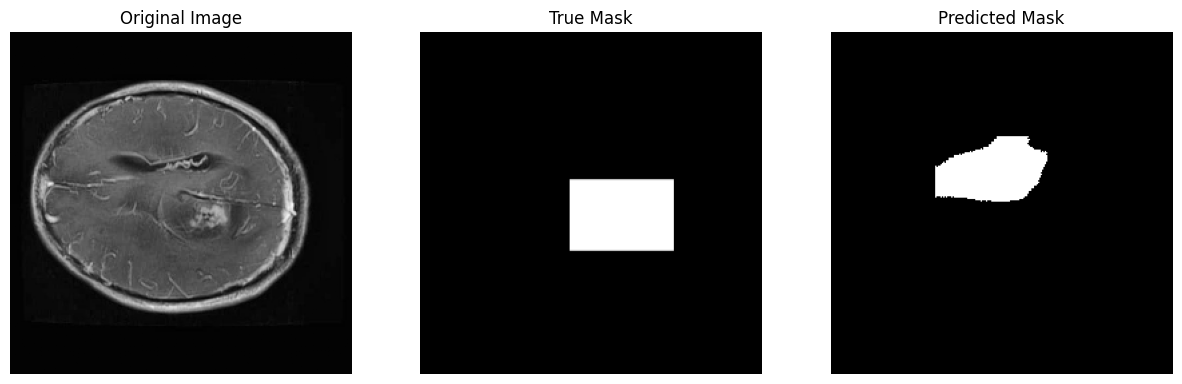

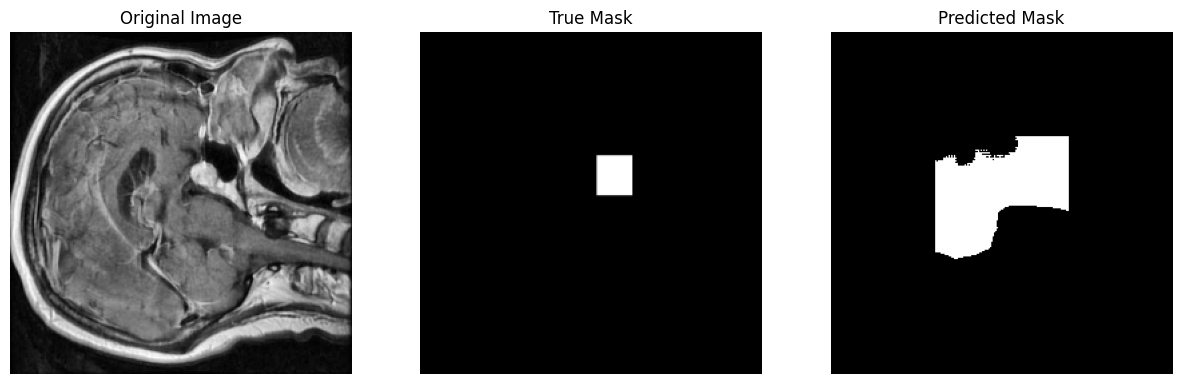

In [23]:
visualize_predictions(model, test_dataset, num_samples=10)

In [18]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import MultiHeadAttention

def downsampling_block(x, n_filters):
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def upsampling_block(x, skip_connection, n_filters):
    u = layers.Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)
    u = layers.concatenate([u, skip_connection])
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(u)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    return c

def multihead_attention_block(query, key, value, num_heads, key_dim):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(query, key, value)
    return attention

def unet_model_with_multihead_attention(input_size=(256, 256, 3), n_filters=32, n_classes=1, num_heads=4, key_dim=64):
    inputs = layers.Input(input_size)
    dblock1, p1 = downsampling_block(inputs, n_filters)
    dblock2, p2 = downsampling_block(p1, n_filters * 2)
    dblock3, p3 = downsampling_block(p2, n_filters * 4)
    dblock4, p4 = downsampling_block(p3, n_filters * 8)

   
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(p4)
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(bottleneck)
    
    attention = multihead_attention_block(bottleneck, bottleneck, bottleneck, num_heads, key_dim)
    attention = layers.LayerNormalization()(attention) 
    
    u6 = upsampling_block(attention, dblock4, n_filters * 8)
    u7 = upsampling_block(u6, dblock3, n_filters * 4)
    u8 = upsampling_block(u7, dblock2, n_filters * 2)
    u9 = upsampling_block(u8, dblock1, n_filters)

    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid' if n_classes == 1 else 'softmax')(u9)

    model = models.Model(inputs, outputs)
    return model

model_with_mha = unet_model_with_multihead_attention(input_size=(256, 256, 3), n_filters=32)

In [19]:
#Change the function 
from tensorflow.keras import backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce

metrics = ["accuracy", dice_coef]

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_with_mha.compile(optimizer=optimizer, loss=combined_loss, metrics=metrics)
model_with_mha.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 32)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 64)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 128)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 256)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 16, 16, 512)    │        525,568 │ conv2d_28[0][0],       │
│ (MultiHeadAttention)      │                        │                │ conv2d_28[0][0],       │
│                           │                        │                │ conv2d_28[0][0]        │
├──────────────────────

 Total params: 8,286,689 (31.61 MB)

 Trainable params: 8,286,689 (31.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model_with_mha.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1641s 18s/step - accuracy: 0.9618 - dice_coef: 0.0598 - loss: 0.7305 - val_accuracy: 0.9627 - val_dice_coef: 0.1434 - val_loss: 0.5794 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1638s 18s/step - accuracy: 0.9615 - dice_coef: 0.1657 - loss: 0.5626 - val_accuracy: 0.9622 - val_dice_coef: 0.2087 - val_loss: 0.5346 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1639s 18s/step - accuracy: 0.9558 - dice_coef: 0.2029 - loss: 0.5406 - val_accuracy: 0.9093 - val_dice_coef: 0.2396 - val_loss: 0.5141 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1654s 18s/step - accuracy: 0.9224 - dice_coef: 0.2492 - loss: 0.5126 - val_accuracy: 0.9294 - val_dice_coef: 0.3058 - val_loss: 0.4863 - learning_rate: 1.0000e-04
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1638s 18s/step - accuracy: 0.9290 - dice_coef: 0.2849 - loss: 0.4962 - val_accuracy: 0.9396 - val_dice_coef: 0.3142 - val_loss: 0.4733 - learning_rate: 1.0000e-04


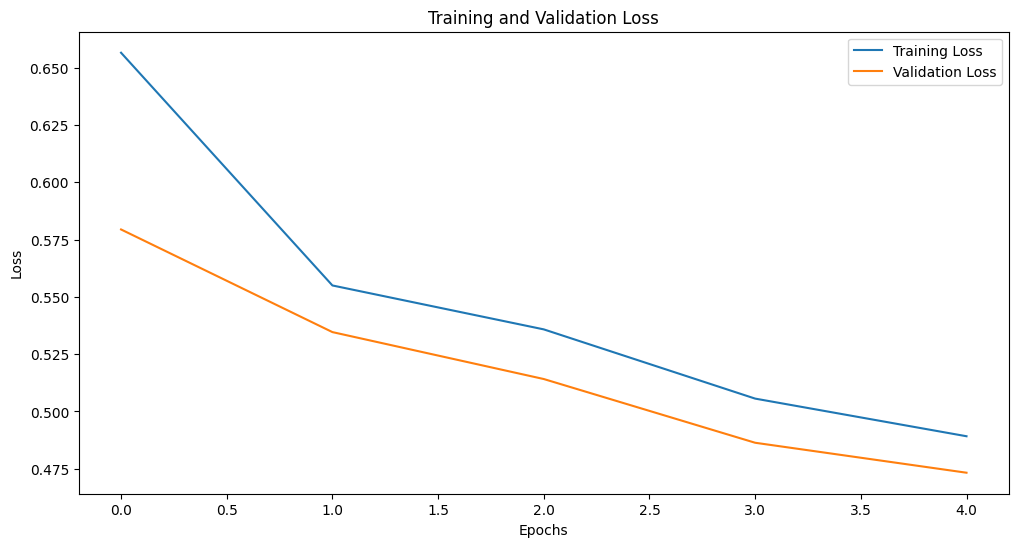

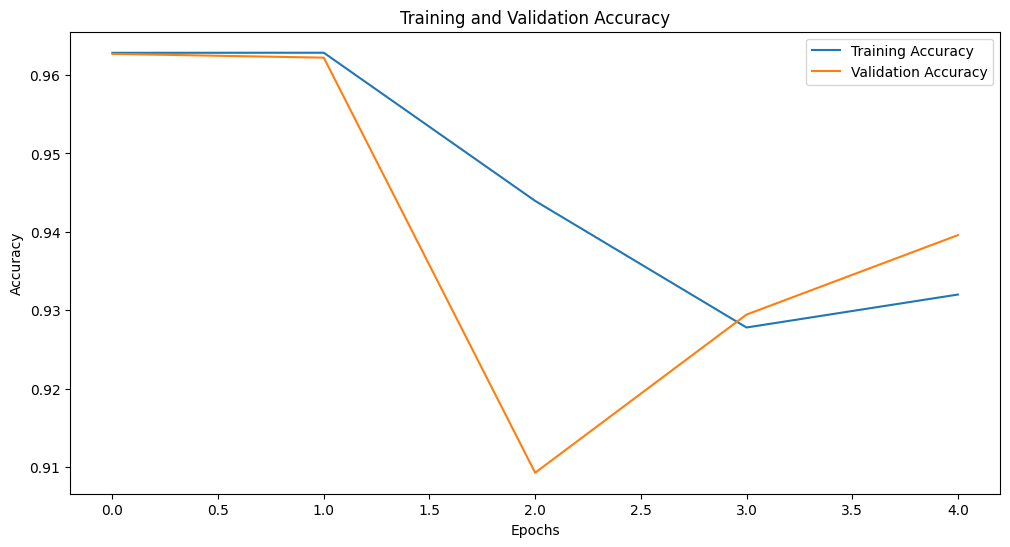

In [21]:
plot_loss(history)
plot_accuracy(history)


In [26]:
test_loss, test_accuracy, test_coef = model_with_mha.evaluate(test_dataset, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Dice Coefficient: {test_coef}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.9393 - dice_coef: 0.3111 - loss: 0.4810
Test Loss: 0.4730830192565918, Test Accuracy: 0.9416249990463257, Test Dice Coefficient: 0.3142455220222473
